In [1]:
%matplotlib inline

In [2]:
import numpy as np
np.random.seed(1335)  # for reproducibility
np.set_printoptions(precision=5, suppress=True, linewidth=150)

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

## Straight line

In [121]:
#Load data
def load_line_data():
    price = pd.DataFrame(np.arange(1,21), index=pd.date_range('2016-01-01', periods=20, freq='D'), columns=['price']) #linearly increasing prices
    price.loc[:,'reward'] = price.diff().values * 1.0
    price.loc[:, 'action'] = 0
    return price

In [5]:
def get_state(xdata, time_step):
    return xdata.iloc[time_step,[0,1]].fillna(0).values

In [66]:
def sig_to_action(action):
    if action == 0:
        return 10000
    elif action == 1:
        return 0
    elif action == 2:
        return -10000

In [7]:
def get_reward(xdata, time_step):
    reward = xdata.iloc[time_step-1, 2] * xdata.iloc[time_step, 1]
    return reward

### Run game

In [8]:
price = load_line_data()
time_step = 0
state = get_state(price, time_step)
price.tail()

,price,reward,action
2016-01-16,16,1.0,0
2016-01-17,17,1.0,0
2016-01-18,18,1.0,0
2016-01-19,19,1.0,0
2016-01-20,20,1.0,0


In [9]:
price.iloc[time_step, 2] = sig_to_action(0)
time_step += 1

In [10]:
reward = get_reward(price, time_step)

In [11]:
reward

100.0

In [12]:
price.iloc[time_step, 2] = sig_to_action(2)
time_step += 1

In [13]:
reward = get_reward(price, time_step)

In [14]:
reward

-100.0

In [15]:
long_sig = price[price.action > 0]
short_sig = price[price.action < 0]

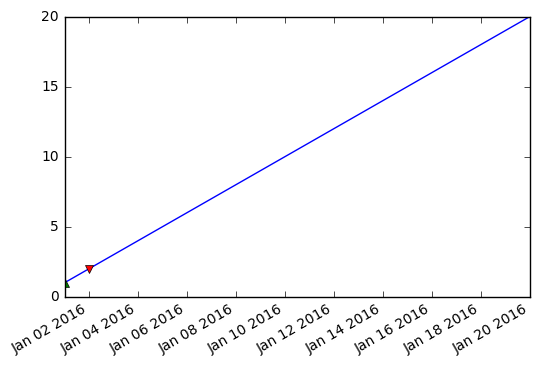

In [16]:
fig, ax1 = plt.subplots()
ax1.plot(price.index, price.price, 'b-')
ax1.plot(long_sig.index, long_sig.price, 'g^')
ax1.plot(short_sig.index, short_sig.price, 'rv')
fig.autofmt_xdate()

### Setting NN

In [116]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(4, init='lecun_uniform', input_shape=(2,)))
model.add(Activation('relu'))
#model.add(Dropout(0.2)) I'm not using dropout in this example

model.add(Dense(4, init='lecun_uniform'))
model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Dense(3, init='lecun_uniform'))
model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)

### Test Training

In [18]:
import random, timeit

In [221]:
epochs = 10
gamma = 0.9 #a high gamma makes a long term reward more valuable
epsilon = 1.0

In [222]:
price = load_line_data()
time_step = 0
state = get_state(price, time_step)
terminal_step = len(price)

qval = model.predict(state.reshape(1,2), batch_size=1)

if (random.random() < epsilon): #choose random action
    action = np.random.randint(0,3) # 3 different action
else: #choose best action from Q(s,a) values
    action = (np.argmax(qval))
    
price.iloc[time_step, 2] = sig_to_action(action)
time_step += 1

reward = get_reward(price, time_step)

new_state = get_state(price, time_step)

newQ = model.predict(new_state.reshape(1,2), batch_size=1)
maxQ = np.max(newQ)

y = np.zeros((1,3))
y[:] = qval[:]

if time_step < terminal_step: #non-terminal state
    update = (reward + (gamma * maxQ))
else: #terminal state
    update = reward
    status = 0

y[0][action] = update
model.fit(state.reshape(1,2), y, batch_size=1, nb_epoch=1, verbose=1)

state = new_state

Epoch 1/1
1/1 [==============================] - 0s - loss: 3220.8337


In [124]:
def testAlgo(price, epochs):
    status = 1
    time_step = 0
    terminal_step = len(price) - 1
    
    #while game still in progress
    while(status == 1):
        state = get_state(price, time_step)        
        qval = model.predict(state.reshape(1,2), batch_size=1)
        action = (np.argmax(qval)) #take action with highest Q-value

        price.iloc[time_step, 2] = sig_to_action(action)
        time_step += 1

        if time_step > terminal_step:
            status = 0        
    
    long_sig = price[price.action > 0]
    short_sig = price[price.action < 0]
    fig, ax1 = plt.subplots()
    ax1.plot(price.index, price.price, 'b-')
    ax1.plot(long_sig.index, long_sig.price, 'g^')
    ax1.plot(short_sig.index, short_sig.price, 'rv')
    fig.autofmt_xdate()
    ax1.set_title("Test Algo after {0} epochs".format(epochs))

### Training!

In [122]:
epochs = 100
gamma = 0.9 #a high gamma makes a long term reward more valuable
epsilon = 0.5

In [123]:
start_time = timeit.default_timer()

for i in range(epochs):

    status = 1
    price = load_line_data()
    time_step = 0
    state = get_state(price, time_step)
    terminal_step = len(price) - 1
    
    #while learning is still in progress
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = model.predict(state.reshape(1,2), batch_size=1)

        if (random.random() < epsilon): #maybe choose random action if not the last epoch
            action = np.random.randint(0,3) # assume 3 different action
        else: #choose best action from Q(s,a) values
            action = (np.argmax(qval))

        #Take action, observe new state S'
        price.iloc[time_step, 2] = sig_to_action(action)
        time_step += 1
        
        #Observe reward
        reward = get_reward(price, time_step)
        
        #get new state
        new_state = get_state(price, time_step)
        
        #Get max_Q(S',a)
        newQ = model.predict(new_state.reshape(1,2), batch_size=1)
        maxQ = np.max(newQ)
        
        y = np.zeros((1,3))
        y[:] = qval[:]
        
        if time_step < terminal_step: #non-terminal state
            update = (reward + (gamma * maxQ))
        else: #terminal state
            update = reward
            status = 0
            
        y[0][action] = update #target output
        model.fit(state.reshape(1,2), y, batch_size=1, nb_epoch=1, verbose=0)
        
        state = new_state

    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

Completed in 6.070000


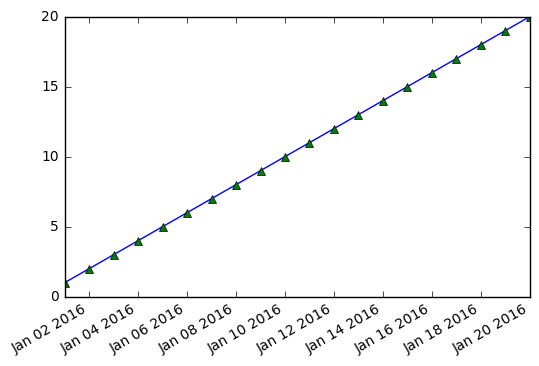

In [125]:
testAlgo(price)

## Sin curve

In [141]:
def load_sin_data():
    price = pd.DataFrame(np.sin(np.arange(500)/30.0), index=pd.date_range('2010-01-01', periods=500, freq='D'), columns=['price']) #linearly increasing prices
    price.loc[:,'reward'] = price.diff().values * 1.0
    price.loc[:, 'action'] = 0
    return price

In [142]:
price = load_sin_data()
time_step = 0
state = get_state(price, time_step)
price.tail()

,price,reward,action
2011-05-11,-0.711785,-0.023804,0
2011-05-12,-0.734799,-0.023014,0
2011-05-13,-0.756996,-0.022197,0
2011-05-14,-0.778352,-0.021356,0
2011-05-15,-0.798843,-0.020491,0


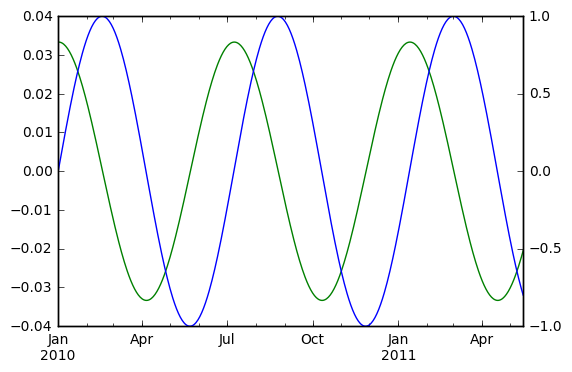

In [143]:
price.price.plot(secondary_y=True)
price.reward.plot()

### Training!

In [144]:
model = Sequential()
model.add(Dense(4, init='lecun_uniform', input_shape=(2,)))
model.add(Activation('relu'))
#model.add(Dropout(0.2)) I'm not using dropout in this example

model.add(Dense(150, init='lecun_uniform'))
model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Dense(3, init='lecun_uniform'))
model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)

In [145]:
epochs = 100
gamma = 0.9 #a high gamma makes a long term reward more valuable
epsilon = 1.

In [146]:
start_time = timeit.default_timer()

for i in range(epochs):

    status = 1
    price = load_sin_data()
    time_step = 0
    state = get_state(price, time_step)
    terminal_step = len(price) - 1
    
    #while learning is still in progress
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = model.predict(state.reshape(1,2), batch_size=1)

        if (random.random() < epsilon): #maybe choose random action if not the last epoch
            action = np.random.randint(0,3) # assume 3 different action
        else: #choose best action from Q(s,a) values
            action = (np.argmax(qval))

        #Take action, observe new state S'
        price.iloc[time_step, 2] = sig_to_action(action)
        time_step += 1
        
        #Observe reward
        reward = get_reward(price, time_step)
        
        #get new state
        new_state = get_state(price, time_step)
        
        #Get max_Q(S',a)
        newQ = model.predict(new_state.reshape(1,2), batch_size=1)
        maxQ = np.max(newQ)
        
        y = np.zeros((1,3))
        y[:] = qval[:]
        
        if time_step < terminal_step: #non-terminal state
            update = (reward + (gamma * maxQ))
        else: #terminal state
            update = reward
            status = 0
            
        y[0][action] = update #target output
        model.fit(state.reshape(1,2), y, batch_size=1, nb_epoch=1, verbose=0)
        
        state = new_state

    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

Completed in 140.640000


In [98]:
state = get_state(price, 150)
state

array([-0.95892,  0.00892])

In [115]:
qval = model.predict(state.reshape(1,2), batch_size=1)
qval

array([[  99.88757,  224.87775,  332.05798]], dtype=float32)

In [107]:
action = np.argmax(qval)

In [108]:
sig_to_action(action)

-10000

In [129]:
def testAlgo(price):
    status = 1
    time_step = 0
    terminal_step = len(price) - 1
    
    #while game still in progress
    while(status == 1):
        state = get_state(price, time_step)
        qval = model.predict(state.reshape(1,2), batch_size=1)
        action = (np.argmax(qval)) #take action with highest Q-value

        price.iloc[time_step, 2] = sig_to_action(action)
        time_step += 1

        if time_step > terminal_step:
            status = 0 
    
    long_sig = price[price.action > 0]
    short_sig = price[price.action < 0]
    fig, ax1 = plt.subplots()
    ax1.plot(price.index, price.price, 'b-')
    ax1.plot(long_sig.index, long_sig.price, 'g^')
    ax1.plot(short_sig.index, short_sig.price, 'rv')
    fig.autofmt_xdate()

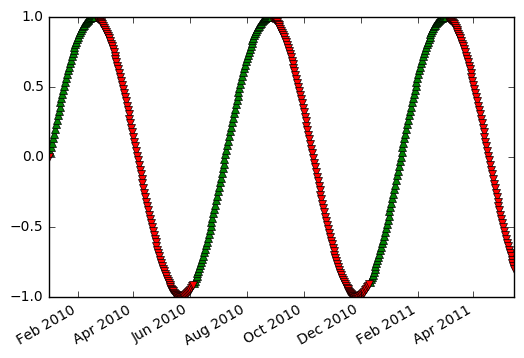

In [147]:
testAlgo(price)